# Basic Visualization of the Surface Normals and Cutout

In [16]:
%matplotlib widget

*Simulation for testing the Concept*

1. Generate Plane in R^3 consisting of vertices
    --> Select point C(x,y,z) for the center of the following cutout shape
2. Deform Plane by random or custom amount
    --> Smooth deformation?

*Real-World Use*

3. Select some points of the plane as markers / Detect Markers
4. Determine Normals of those points
5. Determine normals of all plane faces based on marker normals
6. Cutout the Shape / Generate Locations for Tools use

## *Simulation*:  
**0. Setup**

In [17]:
import numpy as np
import matplotlib.pyplot as plt


class Vertex:    
    def __init__(self, x, y, z, isMarker=False, index=None):
        self.index = index # for tracking the vertex in a mesh
        
        self.point = np.array([x, y, z])  # Coordinates of the vertex
        self.x = x
        self.y = y
        self.z = z

        self.faces = []  # List of faces this vertex belongs to
        self.normal = None  # Normal vector at this vertex

        self.isMarker = isMarker  

    def __repr__(self):
        return f"Vertex({self.x}, {self.y}, {self.z}), isMarker={self.isMarker}), faces={len(self.faces)}), normal={self.normal})"
    
    def compute_normal(self):
        if not self.faces:
            return None
        
        normals = [face.normal for face in self.faces if face.normal is not None]
        if not normals:
            return None
        self.normal = np.mean(normals, axis=0)
        self.normal /= np.linalg.norm(self.normal)
        return self.normal


class Face:
    def __init__(self, A, B, C):
        # A,B,C are now vertex objects

        # Assume only triangular faces for simplicity
        self.A = A
        self.B = B
        self.C = C
        self.vertices = [A, B, C]
        self.centroid = np.mean([A.point , B.point, C.point], axis=0)
        self.normal = self.compute_normal()
    
    def __repr__(self):
        return f"Face(A={self.A.index}, B={self.B.index}, C={self.C.index}, normal={self.normal})"

    def compute_normal(self):
        self.normal = (np.cross(self.B.point - self.A.point, self.C.point - self.A.point))/np.linalg.norm(np.cross(self.B.point - self.A.point, self.C.point - self.A.point))
        return self.normal



**1. Generate Plane in R^3 consisting of vertices**

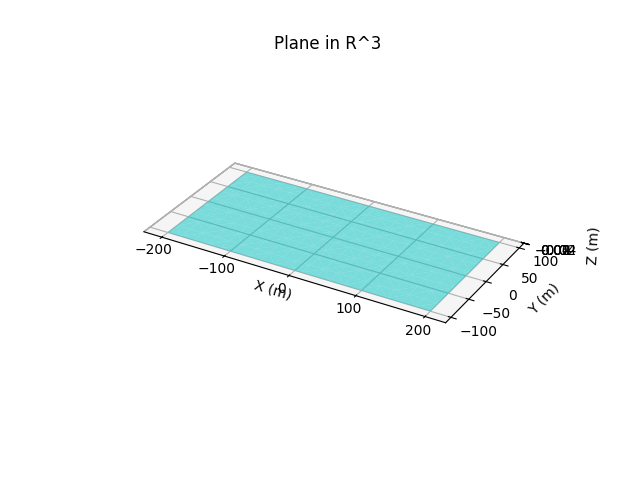

In [32]:

# Plane dimensions
length = 400 # mm
width = 200 # mm

#resolution = 0.05 # vertices/millimeter
resolution = 0.05

# Generate vertices of the plane
x = np.linspace(-length/2, length/2, int(length * resolution))
y = np.linspace(-width/2, width/2, int(width * resolution))
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)  # Plane at z=0

x = X.flatten()
y = Y.flatten()
z = Z.flatten()

vertices = np.vstack((x, y, z)).T


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x, y, z, color='cyan', alpha=0.5)


ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Plane in R^3')
ax.set_aspect('equal')

plt.show()

**2. Deform Plane by random or custom amount** (Maybe use a deformed Blender plane later)

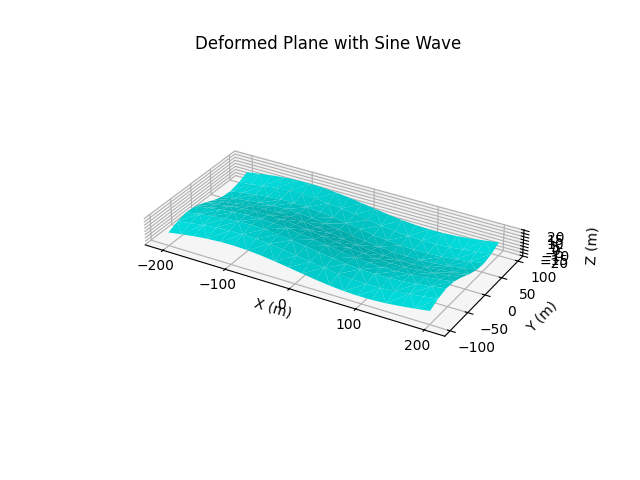

In [33]:
vertices_deformed = vertices.copy()

# Move Vertices in the z-direction with sine wave along the x-axis
x_vals = vertices_deformed[:, 0]
y_vals = vertices_deformed[:, 1]

z_deform_along_x = np.sin(2 * np.pi * (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min()))
z_deform_along_y = np.sin(2 * np.pi * (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min()))

vertices_deformed[:, 2] +=  z_deform_along_x * 10 + z_deform_along_y * 10


# Create a new 3D plot for the sine wave deformation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_trisurf(vertices_deformed[:, 0], vertices_deformed[:, 1], vertices_deformed[:, 2], color='cyan', alpha=1)
#ax2.plot_surface(X, Y, Z, color='cyan', alpha=1)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title('Deformed Plane with Sine Wave')
ax2.set_aspect('equal')

plt.show()





## *Real-World*
**3. Selecting Random Points as Markers // Detect Markers in Real Life**

In [34]:
import random
from scipy.spatial import Delaunay


# Create faces using Delaunay triangulation
vertices_deformed_2d = vertices_deformed[:, :2]  
tri = Delaunay(vertices_deformed_2d) 

# Generate Face and Vertice Pbjects
num_markers = 10
marker_indices = random.sample(range(len(tri.points)), num_markers)

vertices_obj_list = []
for i, point in enumerate(vertices_deformed):
    isMarker = i in marker_indices  # Check if this vertex is a marker

    vertex_obj = Vertex(point[0], point[1], point[2], isMarker = isMarker, index=i)
    vertices_obj_list.append(vertex_obj)


# Create Face Objects
faces_obj_list = []
for simplex in tri.simplices:
    
    A = vertices_obj_list[simplex[0]]
    B = vertices_obj_list[simplex[1]]
    C = vertices_obj_list[simplex[2]]
    
    face_obj = Face(A, B, C)
    faces_obj_list.append(face_obj)

    for vertex in vertices_obj_list:
        if vertex.index in simplex:
            vertex.faces.append(face_obj)





**4. Computing Vertex and Surface Normals** (in reality only the ones of the markers should be known?)

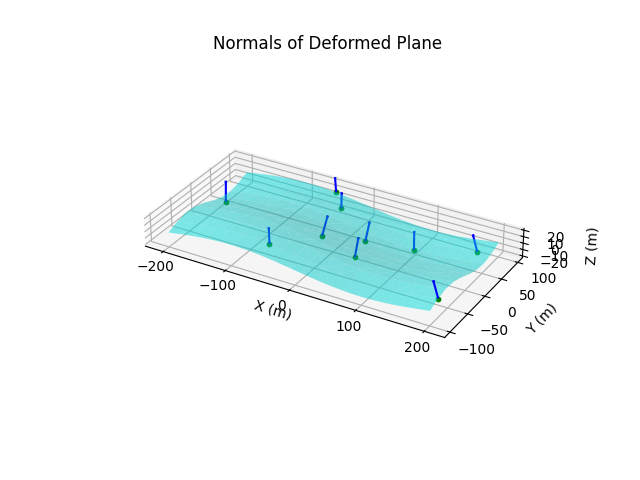

In [35]:
# Calculate vertex normals
for vertex in vertices_obj_list:
    if vertex.faces:
        vertex.compute_normal()
# face normals are already computed in the Face class


# Plot a vector for each normal
fig3 = plt.figure()
ax3 = fig3.subplots(subplot_kw={'projection': '3d'})
ax3.plot_trisurf(vertices_deformed[:, 0], vertices_deformed[:, 1], vertices_deformed[:, 2], color='cyan', alpha=0.5)

"""
for face in faces_obj_list:
    normal = face.normal
    centroid = face.centroid
    ax3.quiver(centroid[0], centroid[1], centroid[2],
               normal[0], normal[1], normal[2],
               length=20, color='red', arrow_length_ratio=0.1)
"""

for vertex in vertices_obj_list:
    if vertex.isMarker:
        ax3.scatter(vertex.x, vertex.y, vertex.z, color='green', s=10, label='Marker' if vertex.index == 0 else "")
    else:
        continue
        #ax3.scatter(vertex.x, vertex.y, vertex.z, color='blue', s=10)

    normal = vertex.normal
    if normal is not None:
        ax3.quiver(vertex.x, vertex.y, vertex.z,
                   normal[0], normal[1], normal[2],
                   length=30, color='blue', arrow_length_ratio=0.1)




ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_zlabel('Z (m)')
ax3.set_title('Normals of Deformed Plane')
ax3.set_aspect('equal')
plt.tight_layout
plt.show()
